In [14]:

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%load_ext tensorboard

In [4]:
content_path = '/content/drive/MyDrive/NST/Images/content_image.jpg'
style_path = '/content/drive/MyDrive/NST/Images/style_image.jpg'

print(content_path)

/content/drive/MyDrive/NST/Images/content_image.jpg


In [5]:
def load_img(img_path):
    ''' This blocks converts image to a tensor and scales to 512 pixel'''
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #converts jpeg image to 3 dimensional rgb or grayscale tensor
    img = tf.image.convert_image_dtype(img,tf.float32) 

    shape = tf.shape(img)[:-1]
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim

    new_shape = tf.cast(shape*scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    img = tf.image.convert_image_dtype(img, tf.uint8)

    return img

def load_images(content_path, style_path):
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image

def imshow(img, title=None):
    if(len(img.shape) > 3):
        img = tf.squeeze(img, axis=0)
    
    plt.imshow(img)
    if title:
        plt.title(title) 


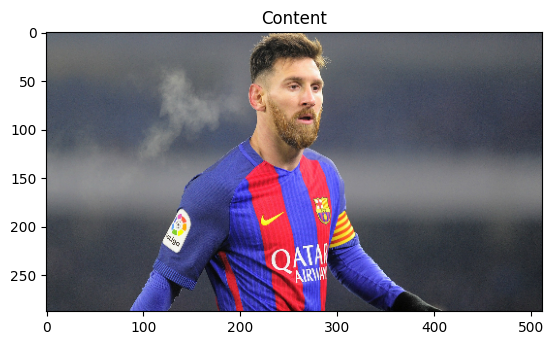

In [6]:
content_image, style_image = load_images(content_path, style_path)

imshow(content_image, 'Content')

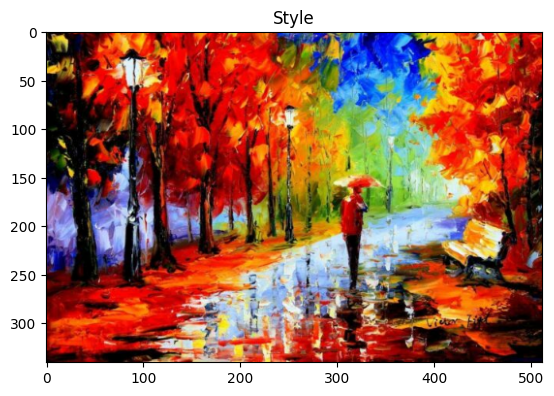

In [7]:
imshow(style_image, 'Style')

In [8]:
# download the inception model and inspect the layers
K.clear_session()

Tmp_inception = tf.keras.applications.InceptionV3()
Tmp_inception.summary()

# delete temporary model
del Tmp_inception

96112376/96112376 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [9]:
# choose the content layer and put in a list
content_layers = ['conv2d_93']

# choose the five style layers of interest
style_layers = ['conv2d', 
                'conv2d_1', 
                'conv2d_2', 
                'conv2d_3', 
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers 

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [10]:
def inception_model(layer_names):

    inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

    inception.trainable = False

    output_layers = [inception.get_layer(name).output for name in layer_names]

    model = tf.keras.models.Model(inputs=inception.input, outputs = output_layers)

    return model



In [15]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception